# This program is employed to compute distance between hard data and representative patterns

A vote mechanism is realized

List version

Sep. 2, 2021

In [1]:
# import necessary package
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Functions

## Called functions

In [2]:
def Standardization_MinMaxScaler(Image, Height, Width):
    '''Perform standardization operation on hard data'''
    
    LowerBound = -9998
    
    InvestigatedImage = np.copy(Image).reshape(-1)
    
    AvailableLocation = np.argwhere(InvestigatedImage > LowerBound).reshape(-1)
    RegionOfInterest = InvestigatedImage[InvestigatedImage>LowerBound]
    
    elevation_min = np.min(RegionOfInterest)
    elevation_max = np.max(RegionOfInterest)
    
    InvestigatedImage[AvailableLocation] = np.copy( (RegionOfInterest - elevation_min)/(elevation_max - elevation_min) )
    InvestigatedImage = InvestigatedImage.reshape((Height, Width))
    return np.copy(InvestigatedImage), np.ndarray.tolist(InvestigatedImage), elevation_min, elevation_max

In [3]:
def Extract_DSPattern_From_SimulationDomain(SimulationDomain, 
                                            SimulationDomain_List, 
                                            SG_height, 
                                            SG_width, 
                                            Center_y, 
                                            Center_x, 
                                            NeighborsAmount, 
                                            SearchingRadius, 
                                            UpperBound, 
                                            LowerBound):
    '''Extract patterns from simulation domain'''
    
    # store the DS pattern values and relative coordinate
    conditioning_value_list = []
    conditioning_y_list = []
    conditioning_x_list = []
    
    circle = 1
    while(True):
        # the top line
        coordinate_x = -circle
        for coordinate_y in range(-circle,circle+1):
            location_y = Center_y+coordinate_y
            location_x = Center_x+coordinate_x
            if(location_y >=0 and location_y<SG_height and location_x >= 0 and location_x<SG_width):
                value = SimulationDomain_List[location_y][location_x]
                if(value >= LowerBound and value <= UpperBound):
                    conditioning_value_list.append(value)
                    conditioning_y_list.append(coordinate_y)
                    conditioning_x_list.append(coordinate_x)
                
        # the right line
        coordinate_y = circle
        for coordinate_x in range(-circle+1,circle+1):
            location_y = Center_y+coordinate_y
            location_x = Center_x+coordinate_x
            if(location_y >=0 and location_y<SG_height and location_x >= 0 and location_x<SG_width):
                value = SimulationDomain_List[location_y][location_x]
                if(value >= LowerBound and value <= UpperBound):
                    conditioning_value_list.append(value)
                    conditioning_y_list.append(coordinate_y)
                    conditioning_x_list.append(coordinate_x)
                
        # the bottom line
        coordinate_x = +circle
        for coordinate_y in range(-circle,circle):
            location_y = Center_y+coordinate_y
            location_x = Center_x+coordinate_x
            if(location_y >=0 and location_y<SG_height and location_x >= 0 and location_x<SG_width):
                value = SimulationDomain_List[location_y][location_x]
                if(value >= LowerBound and value <= UpperBound):
                    conditioning_value_list.append(value)
                    conditioning_y_list.append(coordinate_y)
                    conditioning_x_list.append(coordinate_x)
                
        # the left line
        coordinate_y = -circle
        for coordinate_x in range(-circle+1,circle):
            location_y = Center_y+coordinate_y
            location_x = Center_x+coordinate_x
            if(location_y >=0 and location_y<SG_height and location_x >= 0 and location_x<SG_width):
                value = SimulationDomain_List[location_y][location_x]
                if(value >= LowerBound and value <= UpperBound):
                    conditioning_value_list.append(value)
                    conditioning_y_list.append(coordinate_y)
                    conditioning_x_list.append(coordinate_x)
        
        if(len(conditioning_value_list) > NeighborsAmount):
            break
        elif(circle > SearchingRadius):
            break
        else:
            circle += 1
            
#     plt.imshow(SimulationDomain[max(Center_y-circle,0):min(Center_y+circle+1,SG_height),max(Center_x-circle,0):min(Center_x+circle+1,SG_width)],
#                vmin=0.0,vmax=1.0,cmap='jet')
#     plt.colorbar()
#     plt.title(f'Hard Data Patterns')
#     plt.show()

    return conditioning_value_list, conditioning_y_list, conditioning_x_list

In [4]:
def Extract_DSPattern_From_TrainingImage(TrainingImage, TrainingImage_List,
                                         TI_height, TI_width, 
                                         Center_y, Center_x, 
                                         Conditioning_y, Conditioning_x, 
                                         UpperBound, LowerBound):
    
    training_values_list = []
    
    for relative_y, relative_x in zip(Conditioning_y, Conditioning_x):
        location_y = Center_y + relative_y
        location_x = Center_x + relative_x
        
        if(location_y >=0 and location_y < TI_height and location_x >= 0 and location_x < TI_width):
            value = TrainingImage_List[location_y][location_x]
            if(value >= LowerBound and value <= UpperBound):
                training_values_list.append(value)
            else:
                training_values_list.append((UpperBound+LowerBound)/2)
        else:
            training_values_list.append((UpperBound+LowerBound)/2)
    
    return training_values_list

* Modified

In [5]:
def Calculate_Consistency_Representative_Conditioning_PatternVSPattern(Conditioning_values, Training_values, UpperBound, LowerBound):
    '''calcualte difference between a representative and a conditioning pattern'''
    
    neighborsAmount = len(Conditioning_values) 
        
    # euclidean distance
    if Conditioning_values:
        difference = euclidean(Training_values, Conditioning_values)
    
        # normalized euclidean distance
        difference = difference / (np.sqrt(neighborsAmount) * (UpperBound - LowerBound) )
#     print(f'normalized difference {difference}')
    else:
        difference = np.nan
    
    return difference

In [6]:
def Read_Representative_Locations(TI_Amount):
    '''read information about representative patterns'''
    Clusters_Amount = np.loadtxt(fname='data/Result_RepresentativePatterns_ClusterAmount.txt',dtype=int,delimiter=',')
    Clusters_Amount = Clusters_Amount.reshape(TI_Amount)
    
    Representativs_TI_Index = np.zeros(np.sum(Clusters_Amount))
    start = Clusters_Amount[0]
    for TI_index in range(1,TI_Amount):
        end = start + Clusters_Amount[TI_index]
        Representativs_TI_Index[start:end] = TI_index
        start = end
        
    locations = np.loadtxt(fname='data/Result_RepresentativePatterns_Locations.txt',dtype=int,delimiter=',')
    Representatives_y = locations[::2]
    locations = np.delete(arr=locations,obj=0)
    Representatives_x = locations[::2]
    
#     print(f'Representatives amount {Representativs_TI_Index.shape}')
#     print(f'Representatives amount {Representatives_y.shape}')
#     print(f'Representatives amount {Representatives_x.shape}')
    
    return Clusters_Amount.astype(int), Representativs_TI_Index.astype(int), Representatives_y.astype(int), Representatives_x.astype(int)

In [7]:
def Compute_Distance_HardData_TI(Distance_HD_Pattern_List, Representatives_TI_Index, Num_conditioning, Num_Representatives, TI_Amount):
    '''the minimum distance between hard data and representative become the indicator between HD and TI'''
    
    Distance_HD_TI_List = np.ndarray.tolist( np.full((Num_conditioning, TI_Amount),fill_value=10.0) )
    
    for index_conditioning in range(Num_conditioning):
        for index_representatives, index_TI in enumerate(Representatives_TI_Index):
            distance_pattern = Distance_HD_Pattern_List[index_conditioning][index_representatives]
            
            if(Distance_HD_TI_List[index_conditioning][index_TI] > distance_pattern):
                Distance_HD_TI_List[index_conditioning][index_TI] = distance_pattern
                
    return Distance_HD_TI_List

In [8]:
def TrainingImage_Election_RandomSearching(Distance_HD_TI_List, Num_Conditioning, TI_Amount):
    '''elect a training image from candidate'''
    
    Distance_HD_TI = np.array(Distance_HD_TI_List)
    
    iteration_max = 10000
    
    Fitness_mean = np.full((TI_Amount),fill_value=9999999.9)
    Fitness_variance = np.full((TI_Amount),fill_value=9999999.9)
    SelectedTI_matrix = np.zeros((TI_Amount,TI_Amount),dtype=int)
    
    for TI_Amount_Selected in tqdm(range(1,TI_Amount)):
        # during this iteration, we select #TI_Amount_Selected training images
        
        for iteration_counter in range(iteration_max):
            TrainingImage_indices = np.arange(start=0,stop=TI_Amount,step=1,dtype=int)
            np.random.shuffle(TrainingImage_indices)
            Test_TI = TrainingImage_indices[:TI_Amount_Selected]
            
            DistanceMatrix = Distance_HD_TI[:, Test_TI]
            
            DistanceMatrix_min = np.amin(DistanceMatrix, axis=1)
            
            fitness_mean = np.mean(DistanceMatrix_min)
            fitness_variance = np.var(DistanceMatrix_min)
            
            if(fitness_mean < Fitness_mean[TI_Amount_Selected] and fitness_variance<Fitness_variance[TI_Amount_Selected]):
                solution = np.zeros(TI_Amount,dtype=int)
                solution[Test_TI] = 1
                
                SelectedTI_matrix[TI_Amount_Selected] = solution
                
                Fitness_mean[TI_Amount_Selected] = fitness_mean
                Fitness_variance[TI_Amount_Selected] = fitness_variance
    
    plt.plot(np.arange(1,TI_Amount,1),Fitness_mean[1:])
    plt.title(f'The mean distance between hard data pattern and representatives')
    plt.xlabel(f'The number of selected TI')
    plt.ylabel(f'The mean distance')
    plt.show()
    
    return SelectedTI_matrix

In [9]:
def TrainingImage_Election_ExhaustiveSearching(Distance_HD_TI_List, 
                                                       Num_Conditioning,
                                                       TI_Amount,
                                                       TI_Selected_Num):
    '''elect a training image from candidate'''
    
    print(f'Launching an exhaustive searching program to find the best TI set')
    
    Distance_HD_TI = np.array(Distance_HD_TI_List)
    
    fitness_mean_currentBest = 9999999.9
    fitness_variance_currentBest = 9999999.9
    
    # conduct an exhaustive searching
    Test_TI = np.arange(start=0,stop=TI_Selected_Num,step=1,dtype=int)
    
    while(True):
        
#         print(f'The testing TI set is {Test_TI}')
        
        DistanceMatrix = Distance_HD_TI[:, Test_TI]
            
        DistanceMatrix_min = np.amin(DistanceMatrix, axis=1)

        fitness_mean = np.mean(DistanceMatrix_min)
        
        if(fitness_mean < fitness_mean_currentBest):
            fitness_mean_currentBest = fitness_mean
            
            fitness_variance_currentBest = np.var(DistanceMatrix_min)
            
            CurrentBest_TI = np.copy(Test_TI)
        elif( fitness_mean == fitness_mean_currentBest ):
            
            fitness_variance = np.var(DistanceMatrix_min)
            
            if(fitness_variance < fitness_variance_currentBest):
                
                fitness_mean_currentBest = fitness_mean
            
                fitness_variance_currentBest = fitness_variance

                CurrentBest_TI = np.copy(Test_TI)
                
        if(np.min(Test_TI) == TI_Amount-1):
            break
                
        # update the TI candidate set
        improve_bit = TI_Selected_Num - 1
        while(True):
            value = Test_TI[improve_bit]
            value += 1
            
            if(value == TI_Amount):
                Test_TI[improve_bit] = 0
                improve_bit -= 1
            else:
                Test_TI[improve_bit] = value
                break
            
    print(f'The best TI set is {CurrentBest_TI}')
    print(f'The minimum mean distance is {fitness_mean_currentBest}')
    return CurrentBest_TI

In [10]:
def TrainingImage_Election_ParticleSwarmOptimization(Distance_HD_TI_List, 
                                                       Num_Conditioning,
                                                       TI_Amount,
                                                       TI_Selected_Num):
    '''elect a training image from candidate'''
    
    print(f'Launching the particle swarm optimization algorithm')
    
    Distance_HD_TI = np.array(Distance_HD_TI_List)
    
    iteration_max = 10000  # max number of iterations
    particle_size = 15   # the number of particles    
    w = 0.8    # inertia constant    
    c1 = 2      # cognative constant    
    c2 = 2      # social constant
    
        
    global_best_fitness = 9999999.9
    global_best_position = np.zeros(TI_Selected_Num)
    
    population_position = np.random.uniform(low=0,high=TI_Amount,size=(particle_size, TI_Selected_Num))
    population_position = population_position.astype(int)
#     population_position = np.sort(population_position, axis=1)
    
    population_individual_best_fitness = np.full(shape=particle_size,fill_value=9999999.9)
    population_individual_best_position = np.copy(population_position)
    
    population_velocity = np.random.uniform(low=-1, high=1, size=(particle_size,TI_Selected_Num))
    
    for iteration_counter in range(iteration_max):
        
        # evaluate each individual particle
        for index_individual in range(particle_size):
            Test_TI = np.copy(population_position[index_individual])
            
            DistanceMatrix = Distance_HD_TI[:, Test_TI]
            
            DistanceMatrix_min = np.amin(DistanceMatrix, axis=1)

            fitness = np.mean(DistanceMatrix_min)
            
            # update the individual best
            if(fitness < population_individual_best_fitness[index_individual]):
                population_individual_best_fitness[index_individual] = fitness
                
                population_individual_best_position[index_individual] = np.copy(Test_TI)
                
            # update the global best
            if(fitness < global_best_fitness):
                global_best_fitness = fitness
                
                global_best_position = np.copy(Test_TI)
        
        for index_individual in range(particle_size):

            # update the velocity
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = c1 * r1 * (population_individual_best_position[index_individual] - population_position[index_individual])
            
            social_velocity = c2 * r2 * (global_best_position - population_position[index_individual])
            
            velocity = w * population_velocity[index_individual] + cognitive_velocity + social_velocity
            
            # update the position
            position = population_position[index_individual] + velocity
#             position = np.sort(position)
            position = np.clip(position, a_min=0, a_max=TI_Amount-1)
            population_position[index_individual] = position.astype(int)

    global_best_position = np.sort(global_best_position)
    print(f'Global best position {global_best_position}')
    print(f'Global best fitness {global_best_fitness}')
    return global_best_position

## Main Function

* Modified

In [11]:
def Main_ConsistencyCalculation_RepresentativeSet_ConditioningSet(TrainingImageSet, 
                                                                  TrainingImageSet_List, 
                                                                  TI_Amount, TI_Height, 
                                                                  TI_Width, 
                                                                  SimulationGrid, 
                                                                  SG_Height, 
                                                                  SG_Width):
    '''calculate difference between each representative and each conditioning pattern'''

    DS_NeighborsAmount = 30
    DS_SearchingRadius = 15

    ConditioningStride = 10

    UpperBound = 1.0
    LowerBound = 0.0
    ## Normalize scale to 0-1, where -9999999 is for undefined areas
    SimulationGrid_standardized, SimulationGrid_standardized_List, elevation_max, elevation_min \
                = Standardization_MinMaxScaler(Image = SimulationGrid)
    plt.imshow(SimulationGrid_standardized,vmin=0.0,vmax=1.0,cmap='jet')
    plt.colorbar()
    plt.title(f'Flight lines After Standardization')
    plt.show()

    ## initialize consistency matrix
    DistanceMatrix_HardData_Representatives = []

    ## get information about representatives
    Clusters_Amount, Representatives_TI_Index, Representatives_y, Representatives_x \
        = Read_Representative_Locations(TI_Amount)


    Representatives_TI_Index_List = Representatives_TI_Index.tolist()
    Representatives_y_List = Representatives_y.tolist()
    Representatives_x_List = Representatives_x.tolist()

    ## iterate all conditioning patterns
    DistanceMatrix_HardData_Representatives_List = []
    Locations_y_List = np.ndarray.tolist( np.arange(start=0,stop=SG_Height,step=ConditioningStride) )
    Locations_x_List = np.ndarray.tolist( np.arange(start=0,stop=SG_Width, step=ConditioningStride) )

    Conditioning_Amount = 0

    for location_y in Locations_y_List:
        for location_x in Locations_x_List:

    #             print(f'Conditioning pattern #{Conditioning_Amount}')

            # extract a conditioning pattern 
            conditioning_values_List, conditioning_y_List, conditioning_x_List \
                = Extract_DSPattern_From_SimulationDomain(SimulationDomain = SimulationGrid_standardized, 
                                                          SimulationDomain_List = SimulationGrid_standardized_List,
                                                          SG_height = SG_Height,
                                                          SG_width = SG_Width,
                                                          Center_y = location_y,
                                                          Center_x = location_x, 
                                                          NeighborsAmount = DS_NeighborsAmount,
                                                          SearchingRadius = DS_SearchingRadius,
                                                          UpperBound = UpperBound,
                                                          LowerBound = LowerBound)
            Conditioning_Amount += 1
            # scan all representatives

            for TI_index, training_y, training_x in zip(Representatives_TI_Index_List,
                                                        Representatives_y_List,
                                                        Representatives_x_List):

    #                 print(f'  Training image #{TI_index}')

                # extract a training pattern according to relative coordinates
                training_values_List \
                    = Extract_DSPattern_From_TrainingImage(TrainingImage = TrainingImageSet[TI_index],
                                                           TrainingImage_List = TrainingImageSet_List[TI_index],
                                                           TI_height = TI_Height,
                                                           TI_width = TI_Width,
                                                           Center_y = training_y,
                                                           Center_x = training_x,
                                                           Conditioning_y = conditioning_y_List,
                                                           Conditioning_x = conditioning_x_List,
                                                           UpperBound = UpperBound,
                                                           LowerBound = LowerBound)

                # calculate consistency between a conditioning pattern and a training pattern
                difference \
                    = Calculate_Consistency_Representative_Conditioning_PatternVSPattern(Conditioning_values = conditioning_values_List,
                                                                                         Training_values = training_values_List,
                                                                                         UpperBound = UpperBound,
                                                                                         LowerBound = LowerBound)

                # store difference in computer memory
                DistanceMatrix_HardData_Representatives_List.append(difference)

    # reshape consistency matrix(n_conditioning, n_representatives)
    Representatives_Amount = np.sum(Clusters_Amount)

    DistanceMatrix_HardData_Representatives = np.array(DistanceMatrix_HardData_Representatives_List)
    DistanceMatrix_HardData_Representatives \
            = DistanceMatrix_HardData_Representatives.reshape((Conditioning_Amount, Representatives_Amount))


    DistanceMatrix_HardData_Representatives_List = np.ndarray.tolist(DistanceMatrix_HardData_Representatives)


    # calculate distance between conditioning pattern and training images
    DistanceMatrix_HardData_TrainingImages_List \
        = Compute_Distance_HardData_TI(Distance_HD_Pattern_List = DistanceMatrix_HardData_Representatives_List,
                                       Representatives_TI_Index = Representatives_TI_Index,
                                       Num_conditioning = Conditioning_Amount,
                                       Num_Representatives = Representatives_Amount,
                                       TI_Amount = TI_Amount)

    # conduct a campaign to elect training images
    Ranks_TI, Votes_TI \
        = TrainingImage_Election(Distance_HD_TI_List = DistanceMatrix_HardData_TrainingImages_List,
                                 Num_Conditioning = Conditioning_Amount,
                                 TI_Amount = TI_Amount)

    fig, ax = plt.subplots()
    ax.plot(np.arange(0,TI_Amount,1), Votes_TI)
    ax.set(xlabel='TI index', ylabel='Vote Count',
           title='Training Image Election')
    ax.invert_yaxis()
    ax.grid()
    plt.show()
    
    return Ranks_TI, Votes_TI

In [12]:
def Main_ConsistencyCalculation_RepresentativeSet_ConditioningSet(TrainingImageSet, TrainingImageSet_List,
                                                                  TI_Amount, TI_Height, TI_Width,
                                                                  SimulationGrid, SG_Height, SG_Width,
                                                                  TI_Selected_Num):
    '''calculate difference between each representative and each conditioning pattern'''
    
    DS_NeighborsAmount = 30
    DS_SearchingRadius = 15
    
    ConditioningStride = 10
    
    UpperBound = 1.0
    LowerBound = 0.0
    
    SimulationGrid_standardized, SimulationGrid_standardized_List, elevation_max, elevation_min = \
            Standardization_MinMaxScaler(Image = SimulationGrid,
                                                                                                                               Height = SG_Height,
                                                                                                                               Width = SG_Width)
    plt.imshow(SimulationGrid_standardized,vmin=0.0,vmax=1.0,cmap='jet')
    plt.colorbar()
    plt.title(f'Flight lines After Standardization')
    plt.show()
    
    # initialize consistency matrix
    DistanceMatrix_HardData_Representatives = []
    
    # get information about representatives
    Clusters_Amount, Representatives_TI_Index, Representatives_y, Representatives_x = Read_Representative_Locations(TI_Amount)
    
    Representatives_TI_Index_List = Representatives_TI_Index.tolist()
    Representatives_y_List = Representatives_y.tolist()
    Representatives_x_List = Representatives_x.tolist()
    
    # iterate all conditioning patterns
    DistanceMatrix_HardData_Representatives_List = []
    Conditioning_Amount = 0
    Locations_y_List = np.ndarray.tolist( np.arange(start=0,stop=SG_Height,step=ConditioningStride) )
    Locations_x_List = np.ndarray.tolist( np.arange(start=0,stop=SG_Width, step=ConditioningStride) )
    for location_y in Locations_y_List:
        for location_x in Locations_x_List:
            
#             print(f'Conditioning pattern #{Conditioning_Amount}')
            
            # extract a conditioning pattern 
            conditioning_values_List, conditioning_y_List, conditioning_x_List = Extract_DSPattern_From_SimulationDomain(SimulationDomain = SimulationGrid_standardized,
                                                                                                          SimulationDomain_List = SimulationGrid_standardized_List,
                                                                                                             SG_height = SG_Height,
                                                                                                             SG_width = SG_Width,
                                                                                                             Center_y = location_y,
                                                                                                             Center_x = location_x,
                                                                                                             NeighborsAmount = DS_NeighborsAmount,
                                                                                                             SearchingRadius = DS_SearchingRadius,
                                                                                                             UpperBound = UpperBound,
                                                                                                             LowerBound = LowerBound )
            Conditioning_Amount += 1
            # scan all representatives
            
            for TI_index, training_y, training_x in zip(Representatives_TI_Index_List,
                                                        Representatives_y_List,
                                                        Representatives_x_List):
                
#                 print(f'  Training image #{TI_index}')
                
                # extract a training pattern according to relative coordinates
                training_values_List = Extract_DSPattern_From_TrainingImage(TrainingImage = TrainingImageSet[TI_index],
                                                                       TrainingImage_List = TrainingImageSet_List[TI_index],
                                                                       TI_height = TI_Height,
                                                                       TI_width = TI_Width,
                                                                       Center_y = training_y,
                                                                       Center_x = training_x,
                                                                       Conditioning_y = conditioning_y_List,
                                                                       Conditioning_x = conditioning_x_List,
                                                                       UpperBound = UpperBound,
                                                                       LowerBound = LowerBound)
                
                # calculate consistency between a conditioning pattern and a training pattern
                difference = Calculate_Consistency_Representative_Conditioning_PatternVSPattern(Conditioning_values = conditioning_values_List,
                                                                                                Training_values = training_values_List,
                                                                                                UpperBound = UpperBound,
                                                                                                LowerBound = LowerBound)
                
                # store difference in computer memory
                DistanceMatrix_HardData_Representatives_List.append(difference)
                
    
    # reshape consistency matrix(n_conditioning, n_representatives)
    Representatives_Amount = np.sum(Clusters_Amount)
    
    DistanceMatrix_HardData_Representatives = np.array(DistanceMatrix_HardData_Representatives_List)
    DistanceMatrix_HardData_Representatives = DistanceMatrix_HardData_Representatives.reshape((Conditioning_Amount, Representatives_Amount))
    DistanceMatrix_HardData_Representatives_List = np.ndarray.tolist(DistanceMatrix_HardData_Representatives)
    
    
    # calculate distance between conditioning pattern and training images
    DistanceMatrix_HardData_TrainingImages_List = Compute_Distance_HardData_TI(Distance_HD_Pattern_List = DistanceMatrix_HardData_Representatives_List,
                                                                          Representatives_TI_Index = Representatives_TI_Index,
                                                                          Num_conditioning = Conditioning_Amount,
                                                                          Num_Representatives = Representatives_Amount,
                                                                          TI_Amount = TI_Amount)
    
    # conduct a campaign to elect training images
#     SelectedTI_matrix = TrainingImage_Election_RandomSearching(Distance_HD_TI_List = DistanceMatrix_HardData_TrainingImages_List,
#                                              Num_Conditioning = Conditioning_Amount,
#                                              TI_Amount = TI_Amount)
    
#     Selected_TI = np.argwhere(SelectedTI_matrix[TI_Selected_Num] == 1).reshape(-1)
    
#     Selected_TI = TrainingImage_Election_ExhaustiveSearching(Distance_HD_TI_List = DistanceMatrix_HardData_TrainingImages_List, 
#                                                        Num_Conditioning = Conditioning_Amount,
#                                                        TI_Amount = TI_Amount,
#                                                        TI_Selected_Num = TI_Selected_Num)
    
#     print(f'The selected training images are #{Selected_TI}')
    
    
    Selected_TI = TrainingImage_Election_ParticleSwarmOptimization(Distance_HD_TI_List = DistanceMatrix_HardData_TrainingImages_List, 
                                                                   Num_Conditioning = Conditioning_Amount,
                                                                   TI_Amount = TI_Amount,
                                                                   TI_Selected_Num = TI_Selected_Num)
    
    print(f'The selected training images are #{Selected_TI}')
    
    return Selected_TI

# Run

Load all training images

In [13]:
# input the candidate TIs
TI_Amount = 166
TI_Height = 200
TI_Width = 200
LowerBound = -9998
TrainingImages = np.loadtxt(fname='data/TI_Standardization_166.txt',dtype=float,delimiter=',')
TrainingImages = TrainingImages.reshape((TI_Amount, TI_Height, TI_Width))
TrainingImages_List = TrainingImages.tolist()

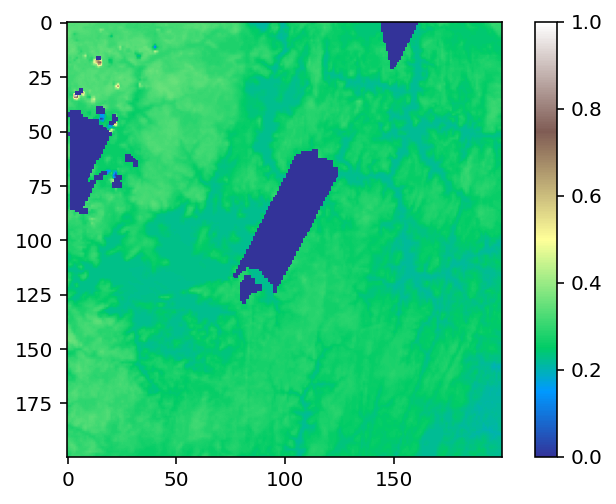

In [14]:
index_TI = 77
plt.imshow(TrainingImages[index_TI],vmin=0,vmax=1,cmap='terrain')
plt.colorbar()

Load radar line data (hard data)

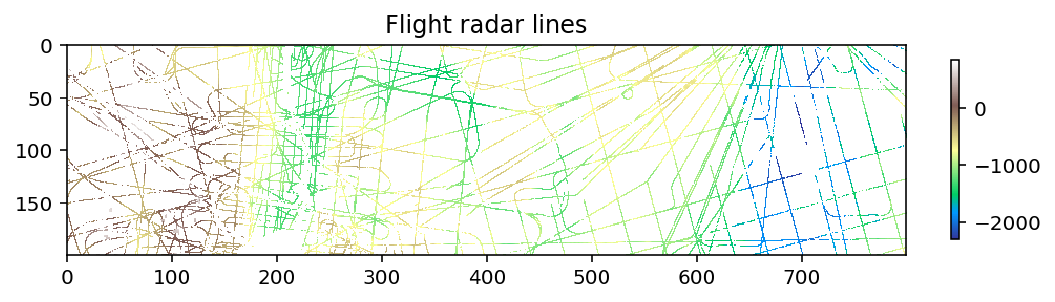

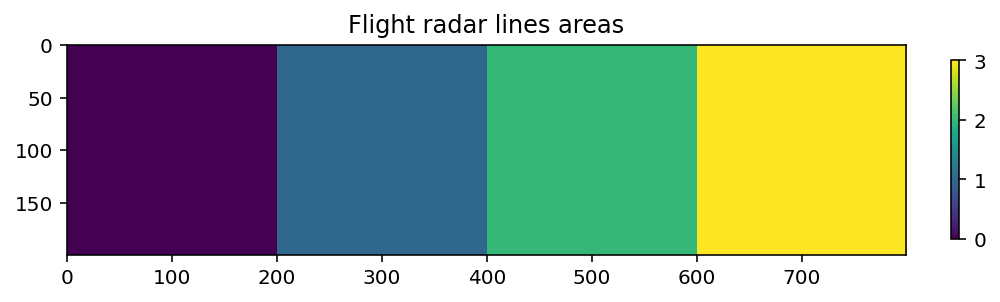

In [15]:
# read hard data
LineData =  np.load('data/LineData.npy')
LineBloc_space = np.load('data/DemoBloc_space.npy')
plt.figure(figsize=(8,2.5))
plt.imshow(LineData, interpolation='none', cmap='terrain')
plt.colorbar(fraction=0.01)
plt.title('Flight radar lines')
plt.show()
plt.figure(figsize=(8,2.5))
plt.imshow(LineBloc_space)
plt.colorbar(fraction=0.01)
plt.title('Flight radar lines areas')
plt.show()

Run main functions

In [42]:
# main function

# the parameter of investigating area
import time
start_time = time.time()
Num_Selected_TrainingImage = 3
Selected_TrainingImage_Index = np.zeros((0))
TI_selection_all = []
## The last local area is empty
for index_area in np.unique(LineBloc_space):
# for index_area in range(1):    
    print(f'Local Area {index_area}')
    
    SG_height = np.argwhere([LineBloc_space==index_area])[:,1].max() - \
                            np.argwhere([LineBloc_space==index_area])[:,1].min()+1
    SG_width = np.argwhere([LineBloc_space==index_area])[:,2].max() - \
                            np.argwhere([LineBloc_space==index_area])[:,2].min()+1
    # slice research area
    HardData = LineData[LineBloc_space==index_area].reshape(SG_height, SG_width)
    
    plt.imshow(HardData,vmin=-2500,vmax=2000,cmap='jet')
    plt.colorbar()
    plt.title(f'Flight lines')
    plt.show()


    # rank TIs according to consistency
    
    Selected_TI = Main_ConsistencyCalculation_RepresentativeSet_ConditioningSet(TrainingImageSet = TrainingImages,
                                                                              TrainingImageSet_List = TrainingImages_List,
                                                                              TI_Amount = TI_Amount,
                                                                              TI_Height = TI_Height,
                                                                              TI_Width = TI_Width,
                                                                              SimulationGrid = HardData,
                                                                              SG_Height = SG_height,
                                                                              SG_Width = SG_width,
                                                                              TI_Selected_Num = Num_Selected_TrainingImage)
    TI_selection_all.append(Selected_TI)
    Selected_TrainingImage_Index = np.concatenate((Selected_TrainingImage_Index, Selected_TI))
    
Selected_TrainingImage_Index = np.unique(Selected_TrainingImage_Index).astype(int)
print(f'The resulting selected training images are {Selected_TrainingImage_Index}')
elapsed_time = time.time() - start_time
print(elapsed_time)

In [207]:
# The last local area LineData[-1] is empty and not saved
np.save('Selected_TrainingImage_Index', Selected_TrainingImage_Index)
np.save('TI_selection_all', TI_selection_all)